In [161]:
import os
import numpy as np
import matplotlib.pyplot as plt

## GPU selection
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "4"

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
import tensorflow as tf

# TensorFlow wizardry
config = tf.compat.v1.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
# Create a session with the above options specified.
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))   

In [162]:
# Convert all layers to 1D version
def conv_block_1d(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv1D(filters, kernelsize, kernel_initializer='he_normal', padding="same")(x)
    if batchnorm:
        conv = layers.BatchNormalization(axis=2)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv1D(filters, kernelsize, kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm:
        conv = layers.BatchNormalization(axis=2)(conv)
    conv = layers.Activation("relu")(conv)
    return conv

def gatingsignal_1d(input, out_size, batchnorm=False):
    x = layers.Conv1D(out_size, 1, padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block_1d(x, gating, inter_shape):
    theta_x = layers.Conv1D(inter_shape, 1, kernel_initializer='he_normal', padding='same')(x)
    phi_g = layers.Conv1D(inter_shape, 1, kernel_initializer='he_normal', padding='same')(gating)
    
    # Here, calculate the size for upsample to match the shape of theta_x
    size = int(theta_x.shape[1] / phi_g.shape[1])
    upsample_g = layers.UpSampling1D(size=size)(phi_g)
    
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv1D(1, 1, kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_x = x.shape
    mul_xg = layers.Multiply()([sigmoid_xg, x])
    res_xg = layers.Reshape((shape_x[1], shape_x[2]))(mul_xg)
    return res_xg

def attentionunet_1d(input_shape, dropout=0.2, batchnorm=True):
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3

    inputs = layers.Input(input_shape) 

    dn_1 = conv_block_1d(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling1D(pool_size=2)(dn_1)
    
    dn_2 = conv_block_1d(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling1D(pool_size=2)(dn_2)
    
    dn_3 = conv_block_1d(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling1D(pool_size=2)(dn_3)
    
    dn_4 = conv_block_1d(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling1D(pool_size=2)(dn_4)
    
    dn_5 = conv_block_1d(pool_4, kernelsize, filters[4], dropout, batchnorm)
    
    gating_5 = gatingsignal_1d(dn_5, filters[3], batchnorm)
    att_5 = attention_block_1d(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling1D(size=2)(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=2)
    up_conv_5 = conv_block_1d(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal_1d(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block_1d(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling1D(size=2)(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=2)
    up_conv_4 = conv_block_1d(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal_1d(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block_1d(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling1D(size=2)(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=2)
    up_conv_3 = conv_block_1d(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal_1d(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block_1d(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling1D(size=2)(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=2)
    up_conv_2 = conv_block_1d(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv1D(1, kernel_size=1)(up_conv_2)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    

'''
# Toy data
input_shape = (1200, 1)
n_samples = 100
X_train = np.random.rand(n_samples, *input_shape)
y_train = np.random.randint(2, size=(n_samples, *input_shape))
'''



'\n# Toy data\ninput_shape = (1200, 1)\nn_samples = 100\nX_train = np.random.rand(n_samples, *input_shape)\ny_train = np.random.randint(2, size=(n_samples, *input_shape))\n'

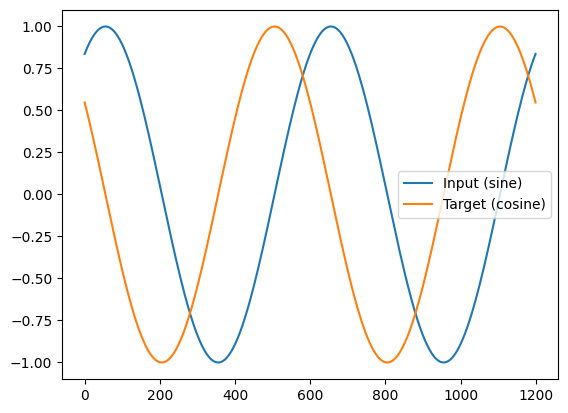

In [167]:
def generate_data(num_samples=1000, sequence_length=100):
    X = np.zeros((num_samples, sequence_length, 1))
    Y = np.zeros((num_samples, sequence_length, 1))
    
    for i in range(num_samples):
        rand_offset = np.random.randint(0, sequence_length)
        X[i, :, 0] = np.sin(np.linspace(0, 4 * np.pi, sequence_length) + rand_offset)
        Y[i, :, 0] = np.cos(np.linspace(0, 4 * np.pi, sequence_length) + rand_offset)
        
    return X, Y

input_shape = (1200, 1)

X, Y = generate_data(1000, input_shape[0])

# Let's visualize the first sample for sanity check
plt.plot(X[0], label='Input (sine)')
plt.plot(Y[0], label='Target (cosine)')
plt.legend()
plt.show()


In [166]:
# Instantiate and compile the model
model = attentionunet_1d(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, 1200, 1)]    0           []                               
                                                                                                  
 conv1d_407 (Conv1D)            (None, 1200, 16)     64          ['input_49[0][0]']               
                                                                                                  
 batch_normalization_477 (Batch  (None, 1200, 16)    64          ['conv1d_407[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_571 (Activation)    (None, 1200, 16)     0           ['batch_normalization_477[0

In [ ]:
# Train the model
model.fit(X, Y, epochs=10, batch_size=16)